In [192]:
from os import  path, makedirs, remove
from zipfile import ZipFile
from shutil import rmtree
import pandas as pd
import numpy as np
import re
import math
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
import matplotlib.pyplot as plt
import xmltodict


In [193]:
if not path.exists('data'):
    makedirs('data')
if not path.exists('data/animelist.csv') and not path.exists('data/anime_with_synopsis.csv'):
    print("Dezipping... (may take a while)")
    with ZipFile("archive.zip", 'r') as zip_ref:
        zip_ref.extractall('data')
        rmtree("data/html folder") 
        remove("data/watching_status.csv")
        remove("data/rating_complete.csv")
        remove("data/anime.csv")

In [194]:
df_anime = pd.read_csv("data/anime_with_synopsis.csv", sep=',', encoding='utf-8')
df_anime

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [195]:
df_anime = df_anime.rename(columns={"sypnopsis": "synopsis"})
df_anime["synopsis"].fillna("", inplace=True)
df_anime = df_anime.rename(columns={"MAL_ID": "anime_id"})
df_anime["synopsis"] = df_anime["synopsis"].replace("No synopsis information has been added to this title. Help improve our database by adding a synopsis here .", "")
df_anime["synopsis"] = df_anime["synopsis"].replace("No synopsis has been added for this series yet. Click here to update this information.", "")
df_anime['synopsis'] = df_anime['Name'] + ' ' + df_anime['Genres'] + ' ' + df_anime['synopsis'] 

df_anime

,anime_id,Name,Score,Genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","Cowboy Bebop Action, Adventure, Comedy, Drama,..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","Cowboy Bebop: Tengoku no Tobira Action, Drama,..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Trigun Action, Sci-Fi, Adventure, Comedy, Dram..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...","Witch Hunter Robin Action, Mystery, Police, Su..."
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural","Bouken Ou Beet Adventure, Fantasy, Shounen, Su..."
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural","Daomu Biji Zhi Qinling Shen Shu Adventure, Mys..."
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural","Mieruko-chan Comedy, Horror, Supernatural ko i..."
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...","Higurashi no Naku Koro ni Sotsu Mystery, Demen..."
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy","Yama no Susume: Next Summit Adventure, Slice o..."


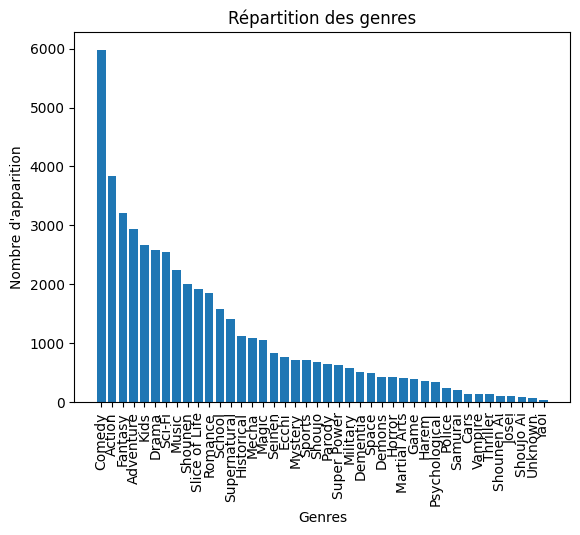

In [196]:
d_genres = defaultdict(int)
for genres in df_anime['Genres'] :
    for i in genres.split(',') :
        d_genres[i.strip()] += 1
d_genres = dict(sorted(d_genres.items(), key=lambda x: x[1], reverse=True))
plt.bar(d_genres.keys(), d_genres.values())
plt.title('Répartition des genres')
plt.xlabel('Genres')
plt.ylabel('Nombre d\'apparition')
plt.xticks(rotation=90)
plt.show()

In [197]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_anime['synopsis'])

tfidf_matrix.shape

(16214, 50214)

In [198]:
def clean(line):
    line = line.lower()
    line = " ".join(line.split(","))
    line = " ".join(line.split("."))
    line = " ".join(line.split(";"))
    line = " ".join(line.split("/"))
    pattern = re.compile(r'(\bfirst|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth)\s+season\b', re.IGNORECASE)
    line = pattern.sub(lambda match: f'season{match.group(1)}', line) 
    pattern = 'No synopsis information has been added to this title. Help improve our database by adding a synopsis'
    line = re.sub(pattern, "", line)
    pattern = 'No synopsis has been added for this series yet. Click here to update this information'
    line = re.sub(pattern, "", line)
    return line
df_anime.loc[:, 'synopsis'] = [clean(x) for x in df_anime['synopsis']]
df_anime['Score'] = pd.to_numeric(df_anime['Score'], errors='coerce')
df_anime_forest = df_anime.dropna(subset=['Score'])
df_anime_forest.loc[:, 'Score'] = df_anime_forest['Score'].round().astype({'Score': 'int32'}) 

In [199]:
X_train, X_test, y_train, y_test = train_test_split(df_anime_forest['synopsis'], df_anime_forest['Score'], test_size=0.2, random_state=42)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [200]:
forest = RandomForestClassifier(n_estimators=100, random_state=123456789)
forest.fit(X_train_tfidf, y_train)

y_pred = forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.52


In [201]:
feature_importances = forest.feature_importances_
feature_names = np.array(tfidf.get_feature_names_out())
selected_features = feature_names[feature_importances > 0.000001] 

In [202]:
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

print('Mots les plus déterminants: ', len(selected_features), '/', len(feature_names) )
for i, (feature, importance) in enumerate(sorted_features):
    if i < 10 :
        print(f'{feature}: {importance:.4f}')
print('Mots les moins déterminants: ', len(selected_features), '/', len(feature_names) )
for i, (feature, importance) in enumerate(sorted_features):
    if i > 38929:
        print(f'{feature}: {importance:.4f}')

Mots les plus déterminants:  25878 / 38940
comedy: 0.0072
source: 0.0056
shounen: 0.0054
dementia: 0.0052
drama: 0.0052
romance: 0.0050
action: 0.0049
school: 0.0041
music: 0.0041
short: 0.0041
Mots les moins déterminants:  25878 / 38940
幸福の科学: 0.0000
手塚治虫: 0.0000
最終章: 0.0000
水猫: 0.0000
白雪とゼン: 0.0000
百瀬ヨシユキ: 0.0000
眠い町: 0.0000
赤猫: 0.0000
闘龍極意書: 0.0000
黄色いしあわせ: 0.0000


In [203]:
tfidf.fit(selected_features)
tfidf_matrix = tfidf.transform(df_anime['synopsis'])

In [204]:
# from sklearn.neighbors import NearestNeighbors

# knn_model = NearestNeighbors(n_neighbors=500, metric='cosine')
# knn_model.fit(tfidf_matrix)
# similar_animes = knn_model.kneighbors(tfidf_matrix)
# knn_model.kneighbors_graph(tfidf_matrix).toarray()

In [205]:
cosine_sim =  cosine_similarity(tfidf_matrix) #knn_model.kneighbors_graph(tfidf_matrix).toarray()
cosine_sim

array([[1.        , 0.31467126, 0.10325566, ..., 0.        , 0.09548198,
        0.11694107],
       [0.31467126, 1.        , 0.11519746, ..., 0.0210538 , 0.02663118,
        0.06523281],
       [0.10325566, 0.11519746, 1.        , ..., 0.        , 0.1048645 ,
        0.01605403],
       ...,
       [0.        , 0.0210538 , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.09548198, 0.02663118, 0.1048645 , ..., 0.        , 1.        ,
        0.04082483],
       [0.11694107, 0.06523281, 0.01605403, ..., 0.        , 0.04082483,
        1.        ]])

In [206]:
df_user = pd.read_csv("data/animelist.csv", sep=',', encoding='utf-8')
df_user.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [207]:
df_user['rating'].value_counts(normalize=True)*100

rating
0     42.872184
8     14.119648
7     13.041580
9      9.371442
6      6.906289
10     6.541001
5      3.689315
4      1.689960
3      0.829208
2      0.499282
1      0.440091
Name: proportion, dtype: float64

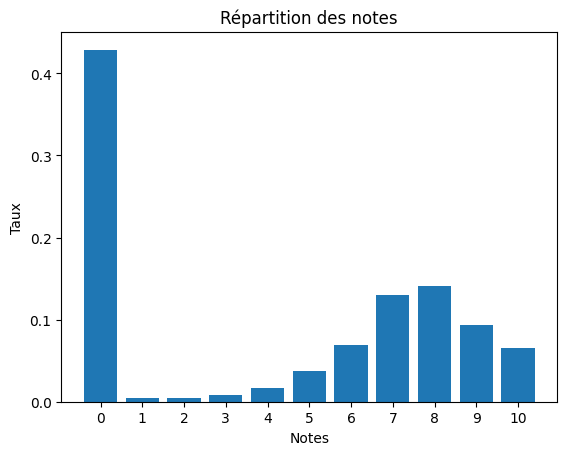

In [208]:
count_ratings = (df_user['rating'].value_counts(normalize=True))

plt.bar(count_ratings.index, count_ratings.values)
plt.title('Répartition des notes')
plt.xlabel('Notes')
plt.ylabel('Taux')
plt.xticks(range(0, 11))
plt.show()

In [209]:
df_user = df_user.astype({'rating': 'int32'})
df_user = df_user[df_user['rating'] != 0]
df_user = df_user.drop(['watching_status'], axis=1)
df_user = df_user.drop(['watched_episodes'], axis=1)
c= df_user['user_id'].value_counts()
df_user = df_user[df_user['user_id'].isin(c[c >= 25].index)].copy()
df_user

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
4,0,21,10
5,0,24,9
...,...,...,...
109224741,353404,243,7
109224742,353404,507,7
109224743,353404,392,9
109224744,353404,882,6


In [210]:
def split_set(user_ratings, add_bad = []):

    train = []
    test = []
    sum_train = 0
    sum_test = 0

    for i, (x, score) in user_ratings.items():
        if i % 2 == 0 or sum_train <= sum_test or x in add_bad:
            train.append((i, x, score))
            sum_train += score
        else:
            test.append((i, x, score))
            sum_test += score

    return train, test

In [211]:
def content_recommend(similarity_matrix, user_ratings, add_bad = [], k = None):
    if k is None:
        set_train , set_test = split_set(user_ratings, add_bad)
        print(f'Train set: {len(set_train)}')
        print(f'Test set: {len(set_test)}')
    else:
        set_train = [(i, x, score) for i, (x, score) in user_ratings.items()]
        set_test = []
    


    ratings = []
    for i in range(len(similarity_matrix)):
        h = 0
        b = 0
        for pos, _, score in set_train:
            h += score * similarity_matrix[i][pos]
            b += similarity_matrix[i][pos]
        if b == 0:
            ratings.append((i, 0))
        else:
            rating = h / b
            if not np.isnan(rating) and not np.isinf(rating):
                ratings.append((i, rating))
            else:
                ratings.append((i, 0))

    ratings.sort(key=lambda x: x[1], reverse=True)
    if k is None:
        return ratings,  set_test
    return ratings[:k], set_test


In [212]:
def balancing_ratings(user_ratings):
    animes_added = []
    select_animes = {y[1]: (y[0], x) for (x, y) in {user_ratings[x][1]: (user_ratings[x][0], x) for x in user_ratings}.items()}
    bad_animes = sorted(select_animes.items(), key=lambda x: x[1][1])[:5]
    nb_ratings = len(user_ratings)
    for anime in bad_animes :
        sim_ind = cosine_similarity(tfidf_matrix[anime[0]], tfidf_matrix)[0].argsort()[::-1][1:int(nb_ratings*0.01)+1]
        # print("----------------------------------")
        # for m in sim_ind:
        #     print(df_anime.iloc[m]['Name'])
        for ind in sim_ind : 
            if df_anime.iloc[ind]['anime_id'] not in animes_added :
                user_ratings[ind] = (df_anime.iloc[ind]['anime_id'],anime[1][1])
                animes_added.append(df_anime.iloc[ind]['anime_id'])
    return animes_added

In [213]:
from collections import defaultdict
user = df_user[df_user['user_id'] == 437]
user_ratings = defaultdict(tuple)
animes_added = []
for i, row in user.iterrows():
    ind = df_anime[df_anime['anime_id'] == row['anime_id']].index[0]
    user_ratings[ind] = (row['anime_id'], row['rating'])
    
# animes_added = balancing_ratings(user_ratings)
        
print(f'len user_ratings: {len(user_ratings)}')

len user_ratings: 549


In [214]:
l, test_set = content_recommend(cosine_sim, user_ratings, animes_added)
ratings_pred = []
ratings_true = []

for x, n in l:
    for i, _, score in test_set:
        if x == i:
            print(f'{df_anime.iloc[x]["Name"]}: {n} (expected: {score})')
            if score > 1:
                ratings_pred.append(n) 
                ratings_true.append(score)
            break

Train set: 280
Test set: 269
D4DJ: First Mix: 9.206923103017553 (expected: 8)
Kandagawa Jet Girls OVA: 8.97205724215926 (expected: 7)
Yes! BanG_Dream!: 8.86860221760295 (expected: 10)
K-On!: 8.776924307435118 (expected: 10)
Black★Rock Shooter (OVA): 8.768604546993798 (expected: 10)
The iDOLM@STER Cinderella Girls: 8.754867597319326 (expected: 10)
Rikaisha: 8.751272013761874 (expected: 8)
Love Live! Nijigasaki Gakuen School Idol Doukoukai: 8.745142855137289 (expected: 10)
Yuru Yuri: 8.744953812987085 (expected: 10)
Garugaku.: Sei Girls Square Gakuin: 8.742051686225828 (expected: 8)
Kandagawa Jet Girls: 8.731767128723709 (expected: 10)
K-On!!: 8.731473550476863 (expected: 10)
Robot Girls Z Plus: 8.726524180022896 (expected: 10)
Ochikobore Fruit Tart: 8.719827000487786 (expected: 9)
Myself; Yourself: 8.716913472406276 (expected: 9)
Lovedol: Lovely Idol: 8.708244673821202 (expected: 10)
Love Live! Sunshine!! The School Idol Movie: Over the Rainbow: 8.70155620884221 (expected: 10)
Boku wa T

In [215]:
mae = mean_absolute_error(ratings_true, ratings_pred)
print("MAE:", mae)

min_rating = 1  
max_rating =  10  
nmae = mae / (max_rating - min_rating)
print("NMAE:", nmae)
class_weights = df_user['rating'].value_counts(normalize=True)
weights = pd.Series(ratings_true).map(class_weights)
wmae = mean_absolute_error(ratings_true, ratings_pred, sample_weight=weights)
print("WMAE:", wmae)


MAE: 1.3979582933318697
NMAE: 0.15532869925909665
WMAE: 1.210310990286346


In [216]:
def error_recommend(user_ratings, animes_added = []):
    l, test_set = content_recommend(cosine_sim, user_ratings, animes_added)
    ratings_pred = []
    ratings_true = []
    for x, n in l:
        for i, _, score in test_set:
            if x == i:
                ratings_pred.append(n) 
                ratings_true.append(score)
                break

    mae = mean_absolute_error(ratings_true, ratings_pred)
    min_rating = 1  
    max_rating =  10  
    nmae = mae / (max_rating - min_rating)
    class_weights = df_user['rating'].value_counts(normalize=True)
    weights = pd.Series(ratings_true).map(class_weights)
    wmae = mean_absolute_error(ratings_true, ratings_pred, sample_weight=weights)
    return mae, wmae

In [217]:
def sampled_range(mini, maxi, num):
    if not num:
        return []
    lmini = math.log(mini)
    lmaxi = math.log(maxi)
    ldelta = (lmaxi - lmini) / (num - 1)
    out = [x for x in set([int(math.exp(lmini + i * ldelta)) for i in range(num)])]
    out.sort()
    return out

In [218]:
n = 0
v = 0
acc_mae, acc_wmae = 0, 0 
for id in sampled_range(df_user['user_id'].min()+1, df_user['user_id'].max(), 200):
    v += 1
    user = df_user[df_user['user_id'] == id]
    if len(user) != 0 :
        user_ratings = defaultdict(tuple)
        animes_added = []
        for i, row in user.iterrows():
            try :
                ind = df_anime[df_anime['anime_id'] == row['anime_id']].index[0]
                user_ratings[ind] = (row['anime_id'], row['rating'])
            except:
                pass
        # animes_added = balancing_ratings(user_ratings)
        if len(user_ratings) > 25 :
           error = error_recommend(user_ratings, animes_added)
           acc_mae += error[0]
           acc_wmae += error[1]
           n += 1
           print(n, "/", v)

Train set: 65
Test set: 52
1 / 1
Train set: 28
Test set: 20
2 / 2
Train set: 164
Test set: 156
3 / 3
Train set: 67
Test set: 57
4 / 4
Train set: 26
Test set: 20
5 / 5
Train set: 168
Test set: 160
6 / 6
Train set: 53
Test set: 38
7 / 7
Train set: 89
Test set: 84
8 / 11
Train set: 33
Test set: 28
9 / 12
Train set: 15
Test set: 12
10 / 13
Train set: 57
Test set: 44
11 / 14
Train set: 138
Test set: 115
12 / 16
Train set: 353
Test set: 351
13 / 17
Train set: 409
Test set: 398
14 / 18
Train set: 47
Test set: 37
15 / 19
Train set: 250
Test set: 237
16 / 20
Train set: 31
Test set: 25
17 / 21
Train set: 45
Test set: 42
18 / 24
Train set: 38
Test set: 25
19 / 25
Train set: 41
Test set: 40
20 / 26
Train set: 104
Test set: 94
21 / 27
Train set: 77
Test set: 77
22 / 28
Train set: 48
Test set: 36
23 / 29
Train set: 133
Test set: 103
24 / 30
Train set: 200
Test set: 195
25 / 31
Train set: 166
Test set: 144
26 / 32
Train set: 52
Test set: 44
27 / 33
Train set: 276
Test set: 259
28 / 34
Train set: 44
T

In [219]:
# Mean Absolute Error
print("MAE :", acc_mae/n)
# Weighted Mean Absolute Error
print("WMAE :", acc_wmae/n)

MAE : 1.0520271718170635
WMAE : 0.8469443571904544


In [220]:
with open('animelist_1702575696_-_7648693.xml', 'r') as file:
    data = file.read()

data_dict = xmltodict.parse(data)


In [221]:
my_list = {}

for data in data_dict['myanimelist']['anime']:
    series_animedb_id = int(data['series_animedb_id'])
    my_score = int(data['my_score'])
    
    # Assuming 'anime_id' is the column name in df_anime
    ind = df_anime[df_anime['anime_id'] == series_animedb_id].index
    
    if not ind.empty and my_score != 0:
        ind = ind[0]
        my_list[ind] = (series_animedb_id, my_score)

In [222]:
l, test_set = content_recommend(cosine_sim, my_list, k=20)
for x, n in l:
    if x not in my_list and df_anime.iloc[x]['Genres'].find('Music') == -1:
        print(f'{df_anime.iloc[x]["Name"]}: {n}')

Yami no Kioku, Yume no Inei: 10.0
Shimajirou to Sora Tobu Fune: 9.649501875624276
Yume 10 Yoru: 9.06112898456185
Lotus: 9.0
Shu Ling Ji: 8.965413220616629
Ninja Tamamaru: Toukaidou Gojuusan-ji: 8.91961196345405
Seisho Gensou Fu: Adam to Eve: 8.86606959853089
Hyoutan: 8.848277070790864
It's Marey O'Clock Now!: 8.830605375889965
Acchi Kocchi: 8.82338382299267
Kkoma Bus Tayo 3: 8.747834535134533
Lei Su Deng Shandian Chong Xian 3: 8.747834535134533
Cocomong 3: 8.747834535134531


In [223]:
import random
test_list = {}
l = df_anime[df_anime['Genres'].str.contains('Horror')].sample(250)
l_id = []

for i, row in l.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 9  + random.randint(-1, 1))

kids = df_anime[df_anime['Genres'].str.contains('Kids')].sample(50)

for i, row in kids.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 2)



In [224]:
l, test_set = content_recommend(cosine_sim, test_list, k=20)
for x, n in l:
    if x not in l_id:
        print(f'{df_anime.iloc[x]["Genres"]}, {df_anime.iloc[x]["Name"]}: {n}')

Unknown, Asuka: Nihon no Rekishi: 9.672521969439245
Samurai, Umi no Momotarou: 9.54224598640202
Unknown, Captain Bal: 9.373175859830555
Unknown, Adauchi Karasu: 9.363904768366138
Unknown, Astar-eul Hyanghae Chaguchagu: 9.363904768366138
Unknown, Afureko! AR: 9.363904768366138
Unknown, Aesop Douwa: 9.363904768366138
Unknown, Chuck Shimezou: 9.363904768366138
Unknown, Tug-Tug: 9.363904768366138
Unknown, Pittanko!! Nekozakana: 9.363904768366138
Unknown, Kaiju Decode: 9.363904768366138
Unknown, Chinsetsu Yoshida Goten: 9.296633875854427
Unknown, Ari to Kaeru: 9.24619831748328
Unknown, Summer Ghost: 9.16827448734046
Romance, Shiohi Girls: Vongole Bianco: 9.14480650812899
Unknown, Nu Sheng Su She Ri Chang Di 2 Ji: 9.126671876686778
Dementia, Yume 10 Yoru: 9.118483015730682
Unknown, Atashi Tenshi Anata Akuma: 9.115921030700346
Dementia, Modern No.2: 9.114138758977587
Romance, Yeon-ae Halujeon: 9.091753208932378


In [225]:
test_list = {}
l = df_anime[df_anime['Genres'].str.contains('Romance')].sample(350)
l_id = []

for i, row in l.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 9  + random.randint(-1, 1))

horror = df_anime[df_anime['Genres'].str.contains('Horror')].sample(50)

for i, row in horror.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 2)

sliceoflife = df_anime[df_anime['Genres'].str.contains('Slice of Life')].sample(100)

for i, row in sliceoflife.iterrows():
    l_id.append(i)
    test_list[i] = (row['anime_id'], 8  + random.randint(-1, 1))

In [226]:
l, test_set = content_recommend(cosine_sim, test_list, k=10)
for x, n in l:
    if x not in l_id:
        print(f'{df_anime.iloc[x]["Genres"]}, {df_anime.iloc[x]["Name"]}: {n}')

Game, 3-gatsu no Lion: Ugoku! Nya Shogi: 9.246077211022925
Sports, Kick Off 2002: 9.1310195295283
Sports, Kagayake! Yuujou no V Sign: 9.1310195295283
Sports, Dokgotak: Taeyang-eul Hyanghae Deonjyeola: 9.131019529528299
Sports, Nae Ireumeun Dokgotak: 9.131019529528299
Sports, Oira no Yakyuu: 9.098923986730513
Sports, Kattobase! Dreamers: Carp Tanjou Monogatari: 9.037518961726825
Game, Treasure Gaust: 9.019551113236563
Martial Arts, Shu Ling Ji: 8.996696758309227
